In [1]:
import pandas as pd
import numpy as np
import random
from cwe2 import database
from sklearn.metrics import precision_recall_fscore_support
import re
from matplotlib import pyplot as plt
import seaborn as sns
import json

In [2]:
path = "/home/name/MY_DRIVES/ProgramFiles/evaluating-deep-learning-based-vulnerability-detection-models-on-realistic-datasets/Malware_Detection/"

In [3]:
linevul_df = pd.read_csv(path + "Data/Compvul_with_CWE_small_predicted_data_LineVul.csv")
deepwukong_df = pd.read_csv(path + "Data/Compvul_with_CWE_small_predicted_data_DeepWukong.csv")
reveal_df = pd.read_csv(path + "Data/Compvul_with_CWE_small_predicted_data.csv")

In [4]:
# df['Vulnerability Classification'] = df['Vulnerability Classification'].map(lambda x: x.strip().rstrip(".") if isinstance(x, str) else x)
# set(df[['Vulnerability Classification', 'CWE ID']].apply(tuple, axis=1).tolist())
#np.unique(df[['Vulnerability Classification', 'CWE ID']].values())#.groupby('Vulnerability Classification').size().reset_index(name='Counts')

In [5]:
linevul_correct_prediction = linevul_df[linevul_df['vul'] == linevul_df['Predicted_Label']]
deepwukong_correct_prediction = deepwukong_df[deepwukong_df['vul'] == deepwukong_df['Predicted_Label']]
reveal_correct_prediction = reveal_df[reveal_df['vul'] == reveal_df['Predicted_Label']]

In [6]:
linevul_incorrect_prediction = linevul_df[linevul_df['vul'] != linevul_df['Predicted_Label']]
deepwukong_incorrect_prediction = deepwukong_df[deepwukong_df['vul'] != deepwukong_df['Predicted_Label']]
reveal_incorrect_prediction = reveal_df[reveal_df['vul'] != reveal_df['Predicted_Label']]

In [7]:
def get_percentage(target_df, total_df, column_name):
    total_count = total_df[total_df[column_name].notnull()].groupby(column_name).size().reset_index(name='Counts')
    total_count[column_name] = total_count[column_name].map(lambda x: x.strip() if isinstance(x, str) else x)
    total_count = total_count.set_index(column_name)
    temp_target_df  = target_df[target_df[column_name].notnull()].groupby(column_name).size().reset_index(name='Counts')
    temp_target_df[column_name] = temp_target_df[column_name].map(lambda x: x.strip() if isinstance(x, str) else x)
    temp_target_df = temp_target_df.set_index(column_name)
    temp_target_df['Counts'] = (temp_target_df['Counts']/total_count['Counts'])*100
    return temp_target_df.sort_values('Counts', ascending=False)
    

In [8]:
def replace_st(text):
    regex = r"-.*Secondary Cluster: .*\n"
    return re.sub(regex, "", text, 0, re.MULTILINE)

In [9]:
def extract_id(text):
    regex = r"\(\d*\)"
    matches = re.findall(regex,text)
    matches = [item.strip("(").strip(")")for item in matches]
    return [int(item)for item in matches if len(item) > 0]

In [10]:
with open("CWE_CLUSTER.json", "r") as f:
    cwe_cluster = json.load(f)

In [11]:
reverse_cluster = dict()
for key in cwe_cluster.keys():
    for value in cwe_cluster[key]:
        reverse_cluster[value] = key

In [12]:
def process_CWE_ID(x):
    if isinstance(x, str):
        x = x.split("CWE-")[-1]
        x = int(x)
        if x in reverse_cluster.keys():
            return str(reverse_cluster[x])
        return None
    else:
        return None

In [13]:
def get_f1_score_df(df):
    types = []
    f1_scores = []
    df['cluster_id'] = df['CWE ID'].map(lambda x: process_CWE_ID(x))
    for id in df[df['cluster_id'].notnull()]['cluster_id'].unique().tolist():
        temp = df[df['cluster_id'] == id]
        p, r, f1, s = precision_recall_fscore_support(y_true=temp['vul'], y_pred=temp['Predicted_Label'], average='binary')
        types.append(id)
        f1_scores.append(f1)
    f1_df = pd.DataFrame({"Type": types, "F1_Score":f1_scores})
    f1_df['F1_Score'] = (f1_df['F1_Score'].fillna(0) *100).round(2)
    f1_df.sort_values(by='F1_Score', inplace=True, ascending=False)
    return f1_df

In [14]:
def add_cluster_id(df):
    types = []
    f1_scores = []
    df['cluster_id'] = df['CWE ID'].map(lambda x: process_CWE_ID(x))
    return df

,cluster_id,Counts
4,890,32.015
9,896,25.207
5,892,13.985
7,894,7.200
2,887,6.814
8,895,5.240
11,899,4.482
1,885,4.259
10,898,0.323
0,1237,0.184


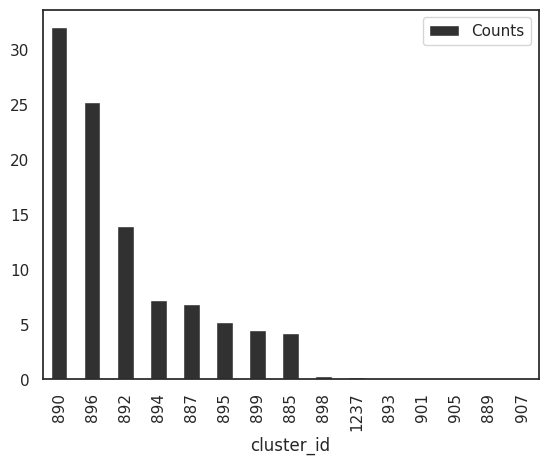

In [33]:
deepwukong_cdf = add_cluster_id(deepwukong_df)
deepwukong_cdf = deepwukong_cdf.groupby(['cluster_id']).size().reset_index(name='Counts').sort_values(by='Counts',ascending=False)
deepwukong_cdf['Counts'] = np.round(deepwukong_cdf['Counts']/ sum(deepwukong_cdf['Counts'].tolist()) * 100,3)
deepwukong_cdf.plot.bar(x='cluster_id', y='Counts')
deepwukong_cdf

In [16]:
deepwukong_f1_df = get_f1_score_df(deepwukong_df)
linevul_f1_df = get_f1_score_df(linevul_df)
reveal_f1_df = get_f1_score_df(reveal_df)

In [42]:
deepwukong_f1_df

,Type,F1_Score
3,895,26.34
0,896,23.46
8,899,21.52
9,901,21.33
4,885,20.62
12,1237,16.36
1,890,16.05
2,894,10.16
7,892,9.86
6,898,9.55


In [18]:
sns.set(style='white')
# sns.set_palette(sns.color_palette("cubehelix"))
# sns.set_palette(sns.dark_palette("#79C"))
sns.set_palette(sns.color_palette("magma",desat=0.01))

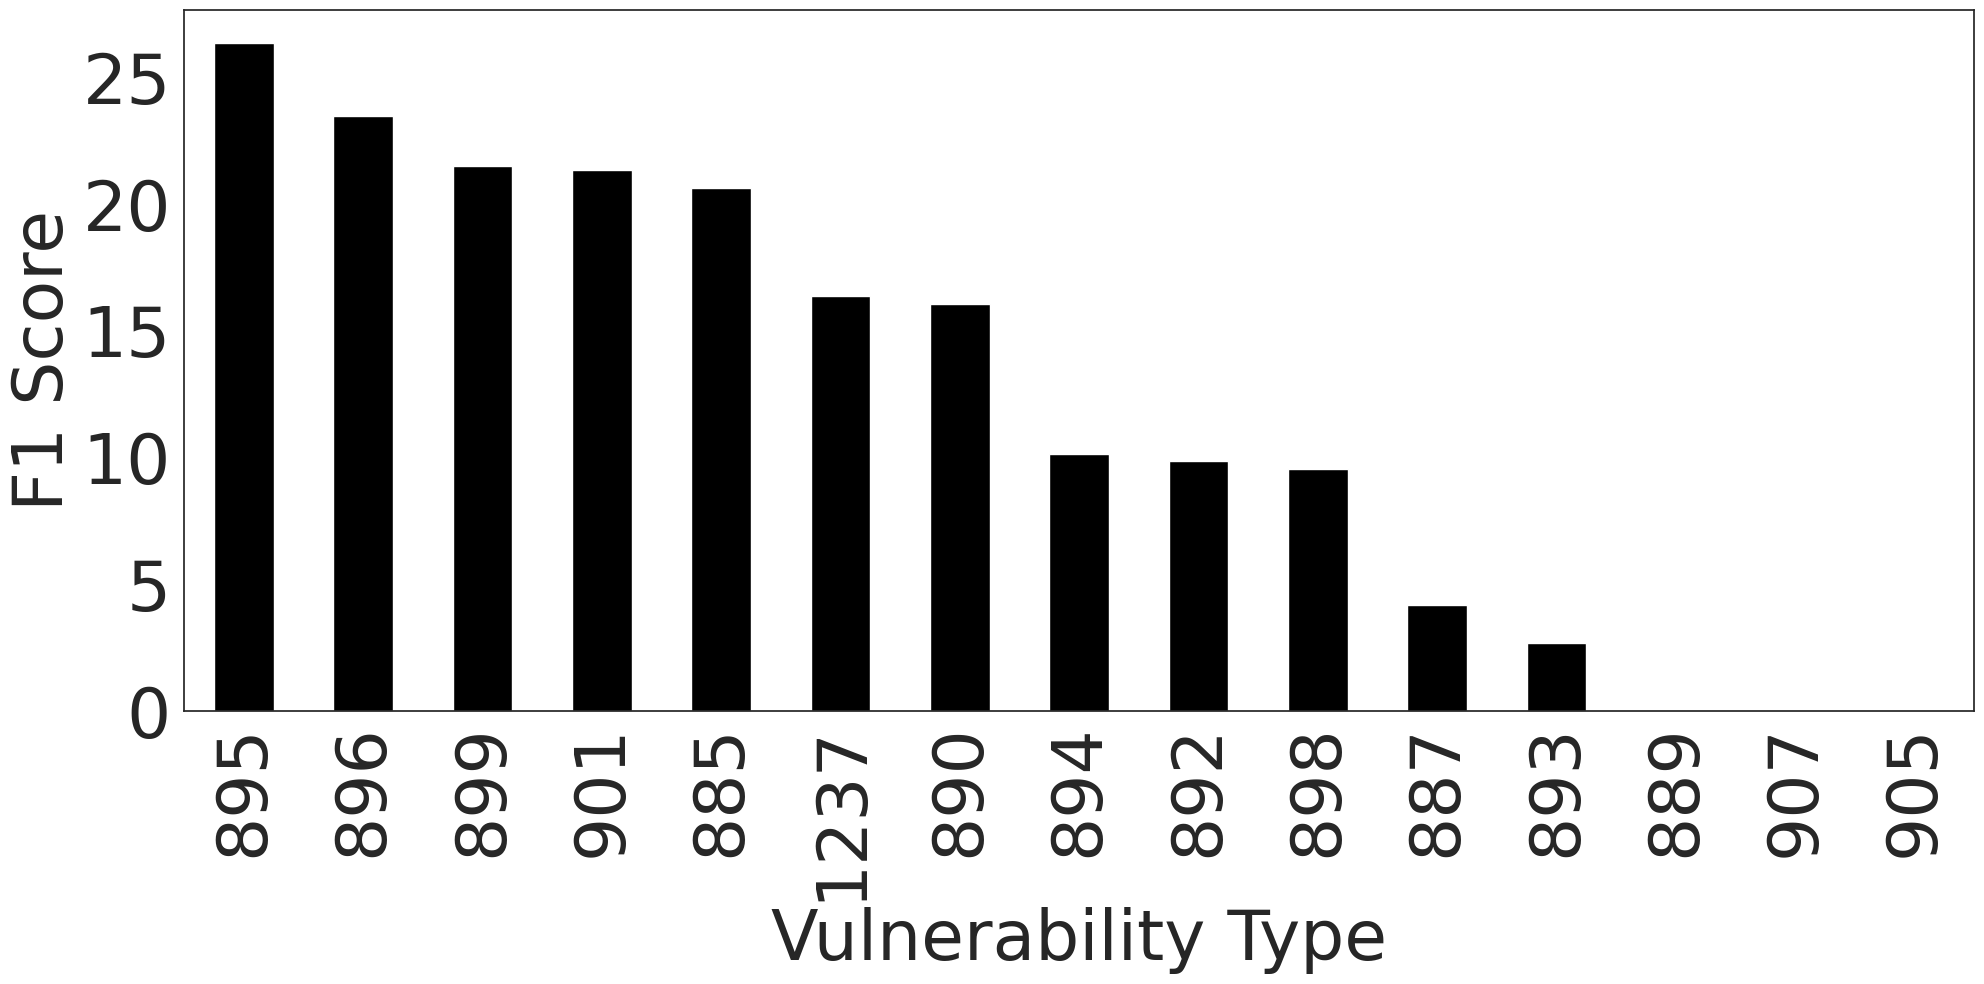

In [19]:
font_size = 50
ax = deepwukong_f1_df.plot.bar(x='Type', y='F1_Score',figsize=(20,10),fontsize=font_size, color=["#000000"]) 
# for container in ax.containers:
#     ax.bar_label(container,fontsize=20)
ax.set_ylabel("F1 Score", fontsize=font_size)
ax.set_xlabel("Vulnerability Type", fontsize=font_size)
ax.get_legend().remove()
plt.tight_layout()
ax.figure.savefig("F1_Score_Cluster_DeepWukong.pdf",format="pdf",dpi=500)

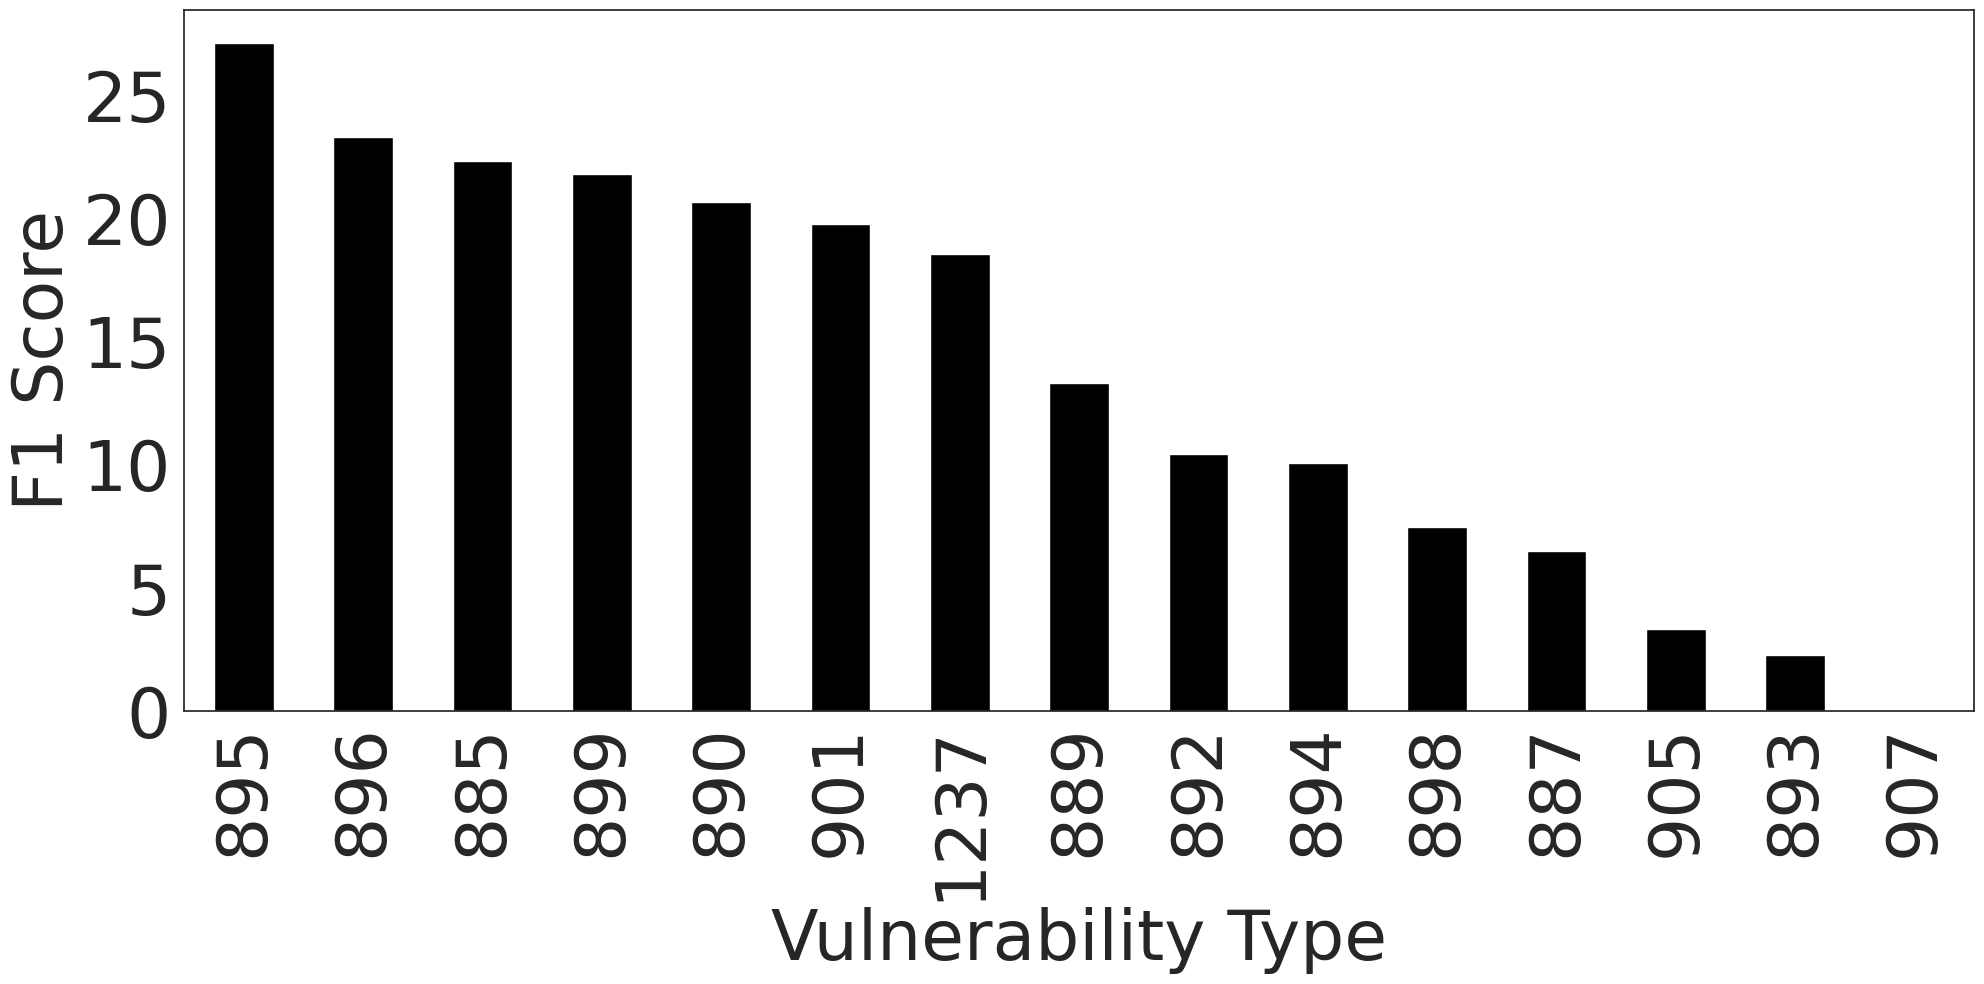

In [20]:
ax = linevul_f1_df.plot.bar(x='Type', y='F1_Score',figsize=(20,10),fontsize=font_size, color=["#000000"]) 
# for container in ax.containers:
#     ax.bar_label(container,fontsize=20)
ax.set_ylabel("F1 Score", fontsize=font_size)
ax.set_xlabel("Vulnerability Type", fontsize=font_size)
plt.tight_layout()
ax.get_legend().remove()
ax.figure.savefig("F1_Score_Cluster_LineVul.pdf",format="pdf",dpi=500)

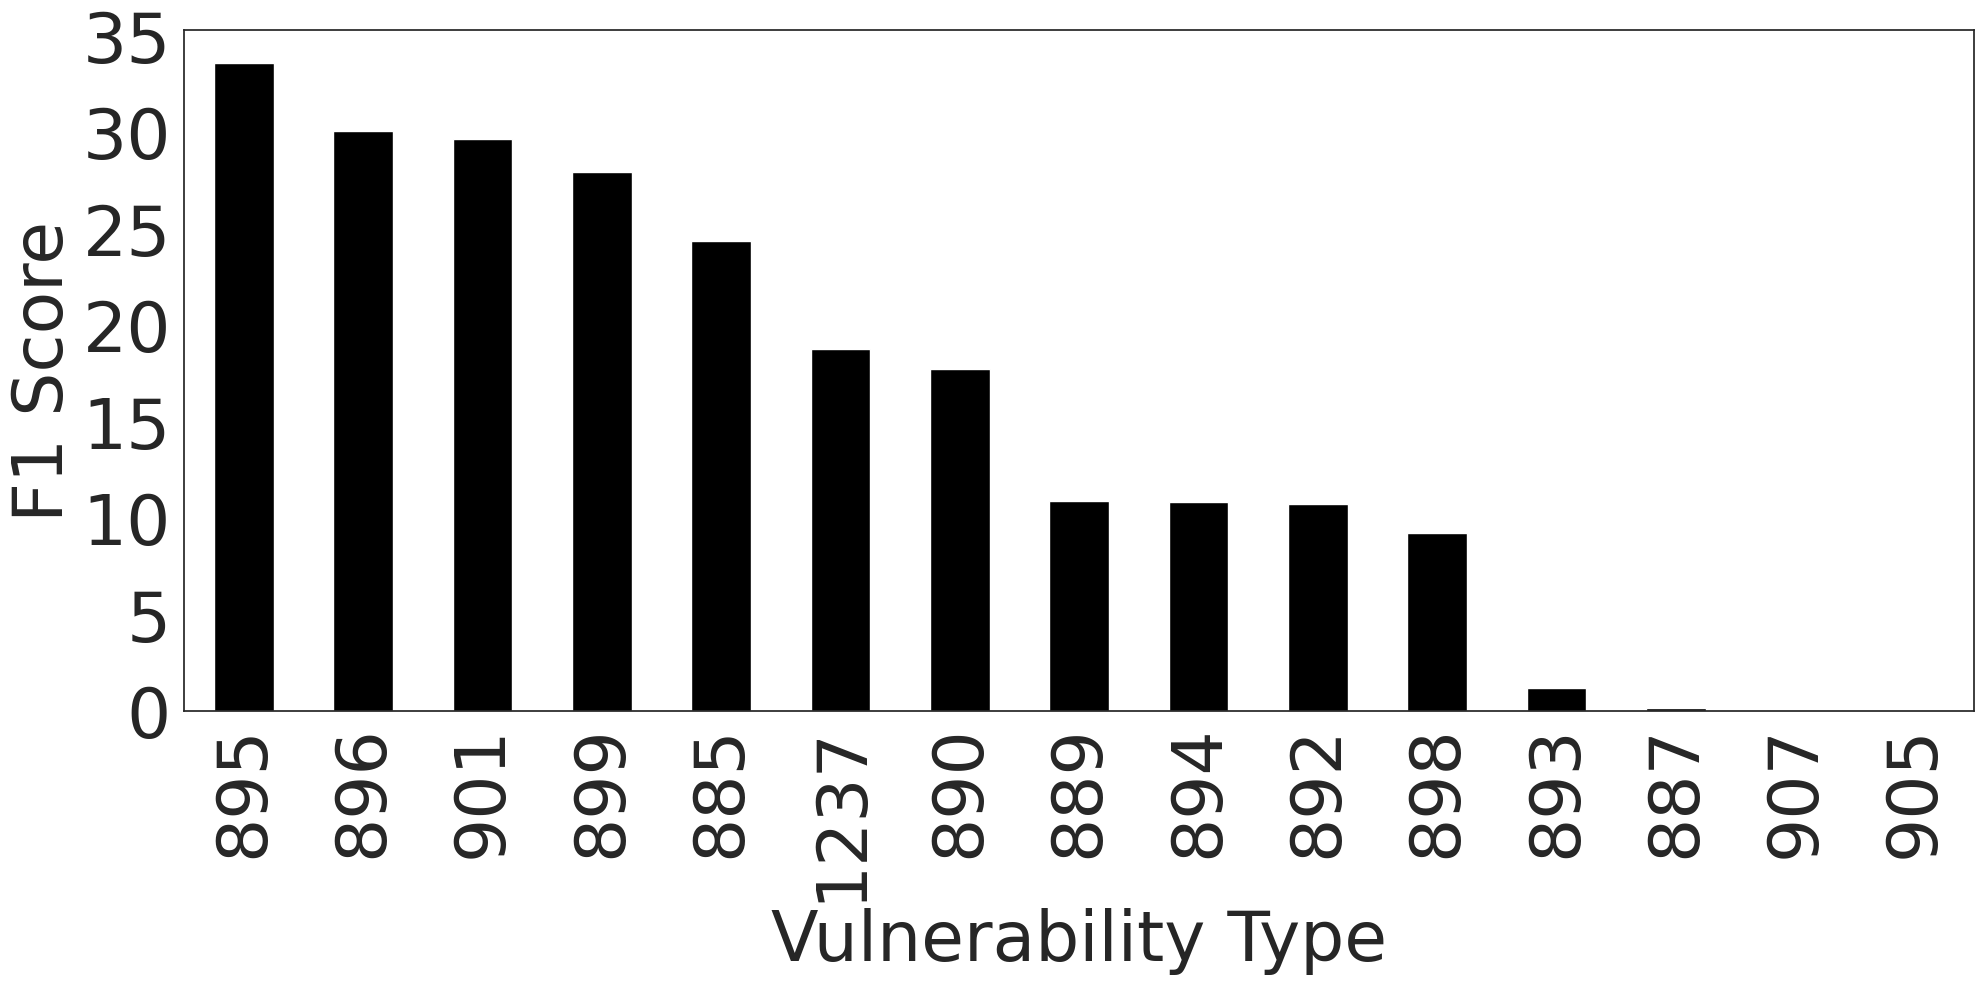

In [21]:
ax = reveal_f1_df.plot.bar(x='Type', y='F1_Score',figsize=(20,10),fontsize=font_size, color=["#000000"]) 
# for container in ax.containers:
#     ax.bar_label(container,fontsize=20)
ax.set_ylabel("F1 Score", fontsize=font_size)
ax.set_xlabel("Vulnerability Type", fontsize=font_size)
plt.tight_layout()
ax.get_legend().remove()
ax.figure.savefig("F1_Score_Cluster_ReVeal.pdf",format="pdf",dpi=500)

In [39]:
deepwukong_df[deepwukong_df['Complexity'].notna()].shape[0]

900133

In [40]:
(deepwukong_df['Complexity'].value_counts()/deepwukong_df[deepwukong_df['Complexity'].notna()].shape[0])*100

Complexity
Low       60.519390
Medium    33.937207
High       5.009482
???        0.533921
Name: count, dtype: float64

In [23]:
def get_f1_score_df_by_complexity(df):
    types = []
    f1_scores = []
    for id in df[df['Complexity'].notnull()]['Complexity'].unique().tolist():
        temp = df[df['Complexity'] == id]
        p, r, f1, s = precision_recall_fscore_support(y_true=temp['vul'], y_pred=temp['Predicted_Label'], average='binary')
        if id == "???":
            id = 'Unidentified'
            continue
        types.append(id)
        f1_scores.append(f1)
    f1_df = pd.DataFrame({"Severity": types, "F1_Score":f1_scores})
    f1_df['F1_Score'] = (f1_df['F1_Score'].fillna(0) *100).round(2)
    f1_df.sort_values(by='Severity', inplace=True, ascending=False)
    return f1_df

In [24]:
deepwukong_complexity_df = get_f1_score_df_by_complexity(deepwukong_df)
linevul_complexity_df = get_f1_score_df_by_complexity(linevul_df)
reveal_complexity_df = get_f1_score_df_by_complexity(reveal_df)

In [35]:
combined_severity = pd.DataFrame({
    "DeepWukong": deepwukong_complexity_df['F1_Score'].tolist(),
    "LineVul": linevul_complexity_df['F1_Score'].tolist(),
    "ReVeal": reveal_complexity_df['F1_Score'].tolist(),
    
},
            index= deepwukong_complexity_df['Severity'].tolist())
combined_severity = combined_severity.reindex(index=['Low', 'Medium', 'High'])

<Figure size 640x480 with 0 Axes>

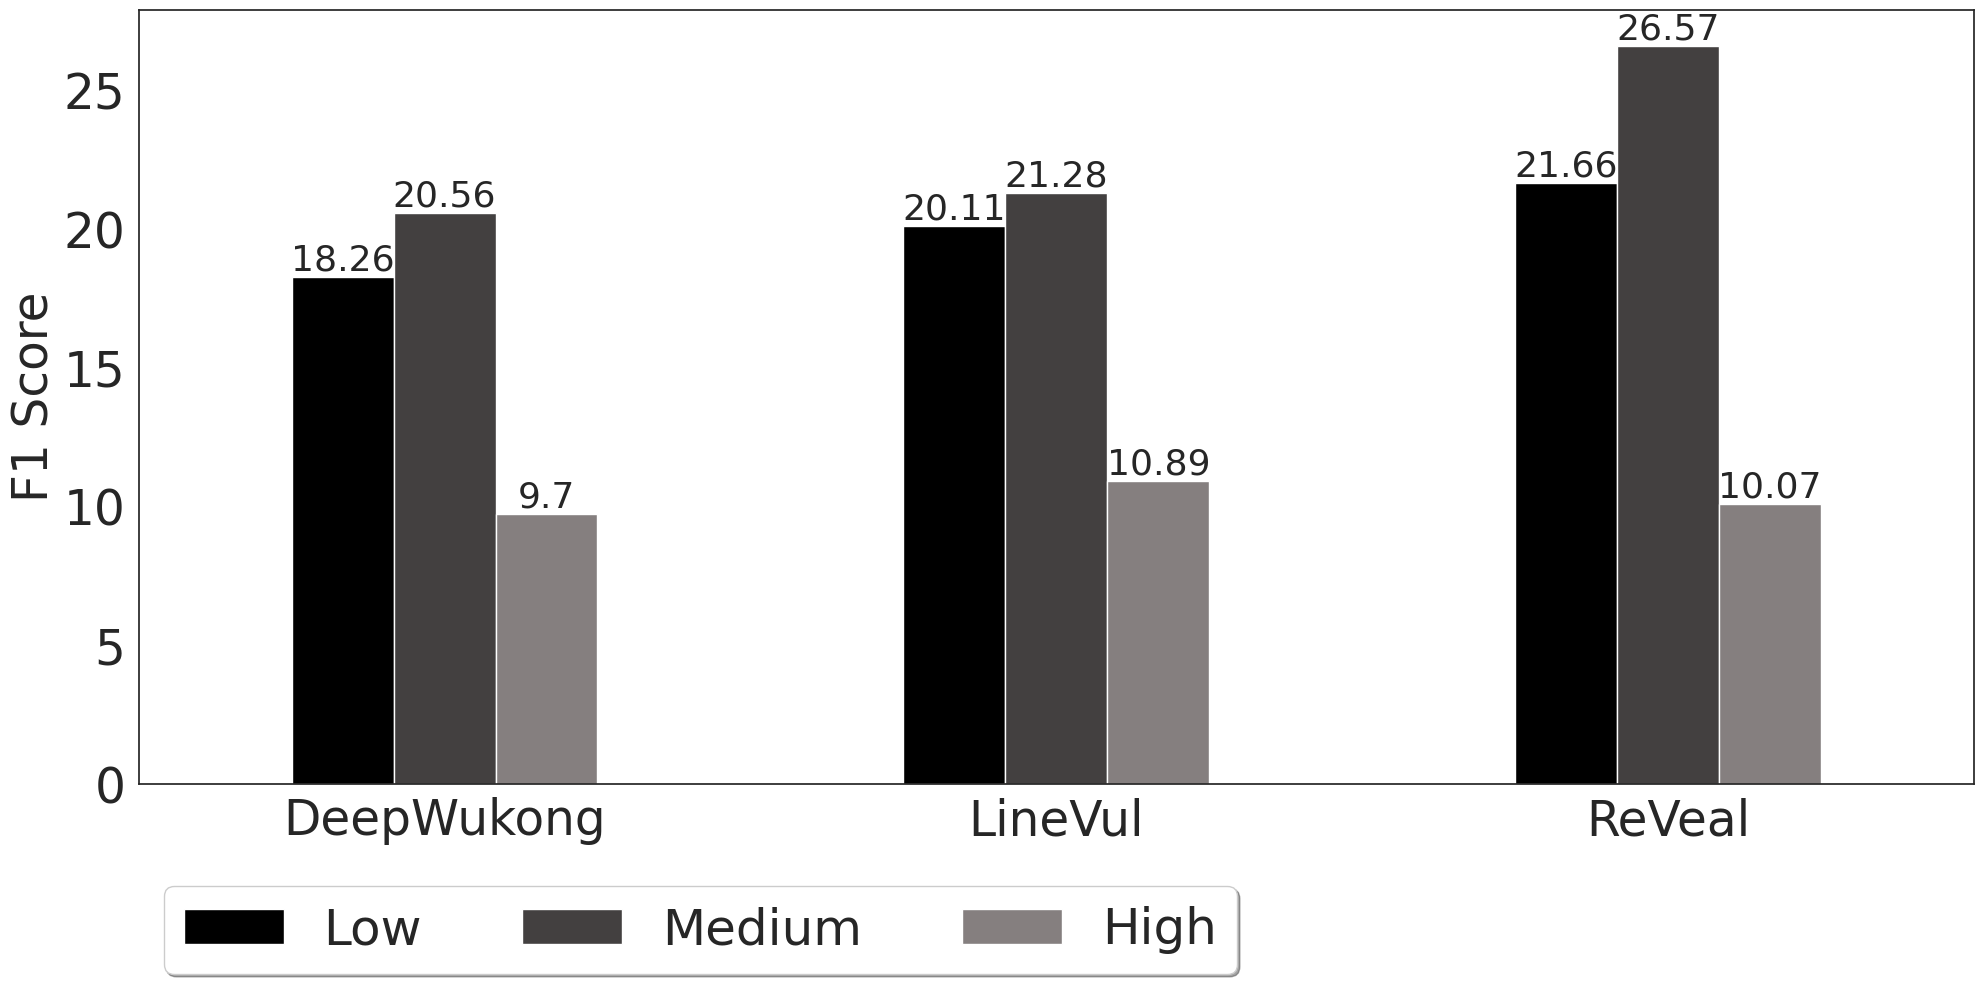

In [36]:
plt.tight_layout()
ax = combined_severity.transpose().plot.bar(rot=0,figsize=(20,10),fontsize=35, color=("#000000", "#434040", "#857F7F")) #, hatch=['--', '+', 'x']) #, color=["#252625", "#343635","#444544", "#565756"])
for container in ax.containers:
    ax.bar_label(container,fontsize=26)
temp_hatches = ["/", "-", "+", "x"]
hatches = []
# for item in temp_hatches:
#     hatches.extend([item] * (len(temp_hatches) - 1))
# for i, patch in enumerate(ax.patches):
#     patch.set_hatch(hatches[i])
ax.legend(loc='upper left', bbox_to_anchor=(0, -0.1),
          ncol=4, fancybox=True, shadow=True,fontsize=36)

ax.set_ylabel("F1 Score", fontsize=35)
plt.tight_layout()
ax.figure.savefig("Severity.pdf",format="pdf",dpi=500)

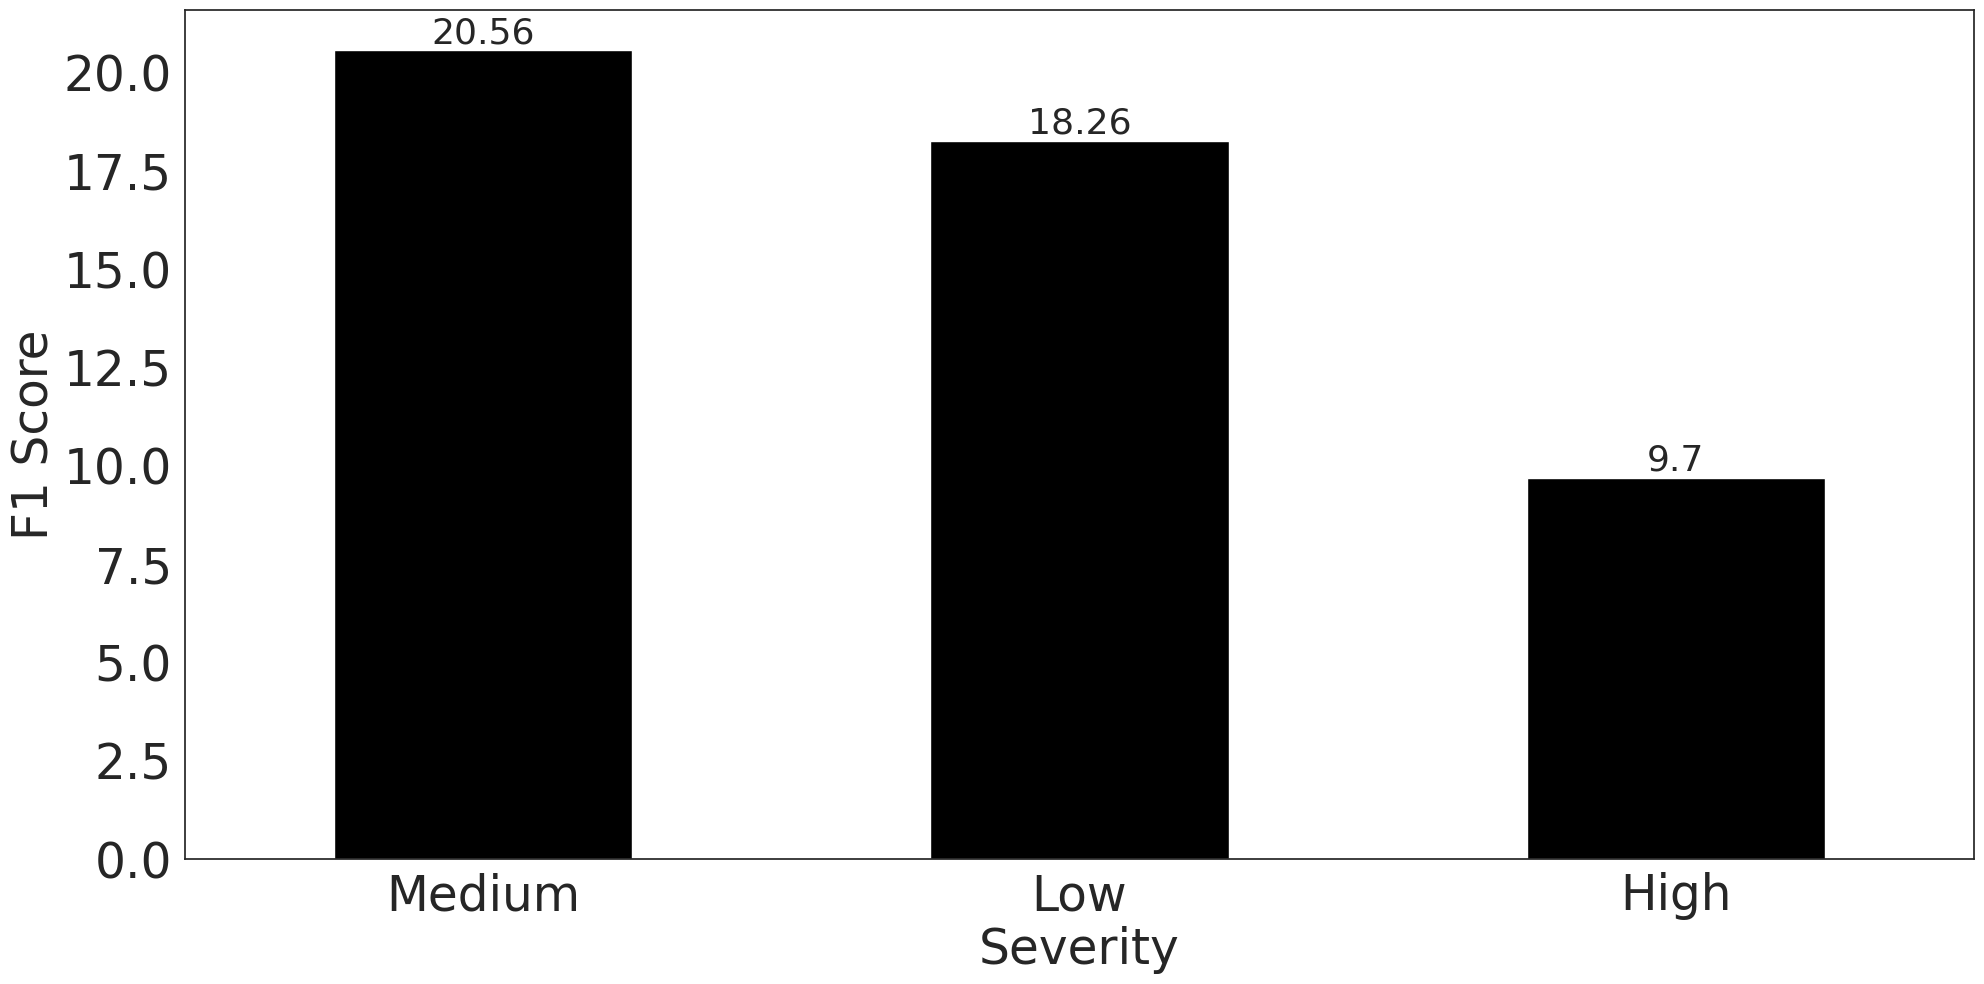

In [27]:
ax = deepwukong_complexity_df.plot.bar(x='Severity', y='F1_Score',rot=0, figsize=(20,10),fontsize=35, color=["#000000"]) 
for container in ax.containers:
    ax.bar_label(container,fontsize=26)
ax.set_ylabel("F1 Score", fontsize=35)
ax.set_xlabel("Severity", fontsize=35)
plt.tight_layout()
ax.get_legend().remove()
ax.figure.savefig("F1_Score_Complexity_DeepWukong.pdf",format="pdf",dpi=500)

In [28]:
ax = linevul_complexity_df.plot.bar(x='Complexity', y='F1_Score',rot=0, figsize=(20,10),fontsize=35) 
for container in ax.containers:
    ax.bar_label(container,fontsize=26)
ax.set_ylabel("F1 Score", fontsize=35)
ax.set_xlabel("Complexity", fontsize=35)
plt.tight_layout()
ax.figure.savefig("F1_Score_Complexity_LineVul.pdf",format="pdf",dpi=500)

KeyError: 'Complexity'

In [ ]:
ax = reveal_complexity_df.plot.bar(x='Complexity', y='F1_Score',rot=0, figsize=(20,10),fontsize=35) 
for container in ax.containers:
    ax.bar_label(container,fontsize=26)
ax.set_ylabel("F1 Score", fontsize=35)
ax.set_xlabel("Complexity", fontsize=35)
plt.tight_layout()
ax.figure.savefig("F1_Score_Complexity_ReVeal.pdf",format="pdf",dpi=500)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
def get_f1_score_complexity_type(df):
    types = []
    f1_scores = []
    df['cluster_id'] = df['CWE ID'].map(lambda x: process_CWE_ID(x))
    cwe_type_dict = {int(item):[] for item in df[df['cluster_id'].notnull()]['cluster_id'].unique().tolist()}
    comp_type = [comp for comp in df[df['Complexity'].notnull()]['Complexity'].unique().tolist()]
    comp_type.remove("???")
    for comp in comp_type:
        for id in df[df['cluster_id'].notnull()]['cluster_id'].unique().tolist():
            temp = df[(df['cluster_id'] == id) & (df['Complexity'] == comp)]
            #print(len(temp), comp)
            p, r, f1, s = precision_recall_fscore_support(y_true=temp['vul'], y_pred=temp['Predicted_Label'], average='binary')
            cwe_type_dict[int(id)].append(np.round(f1*100,2))
    comp_type = [comp if comp != "???" else "Unidentified" for comp in comp_type]
    print(comp_type)
    complexity_type_df = pd.DataFrame(cwe_type_dict, index=comp_type)
    complexity_type_df = complexity_type_df.reindex(index = ["High", "Medium", "Low"]).reindex(sorted(complexity_type_df.columns, reverse=False), axis=1)
    return complexity_type_df

In [ ]:
deepwukong_comnplexity_type_df = get_f1_score_complexity_type(deepwukong_df)
fig, ax = plt.subplots(figsize=(20,10)) 
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
sns.set(font_scale=3)
hmp = sns.heatmap(deepwukong_comnplexity_type_df, annot=True,ax=ax, cmap='crest', annot_kws={"size": 25})
ax.figure.savefig("Heatmap_DeepWukong.pdf",format="pdf",dpi=500)

In [ ]:
linevul_comnplexity_type_df = get_f1_score_complexity_type(linevul_df)
fig, ax = plt.subplots(figsize=(20,10)) 
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
sns.set(font_scale=3)
hmp = sns.heatmap(linevul_comnplexity_type_df, annot=True,ax=ax, cmap='crest', annot_kws={"size": 25})
ax.figure.savefig("Heatmap_LineVul.pdf",format="pdf",dpi=500)

In [ ]:
reveal_comnplexity_type_df = get_f1_score_complexity_type(reveal_df)
fig, ax = plt.subplots(figsize=(15,10)) 
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
sns.set(font_scale=3)
hmp = sns.heatmap(reveal_comnplexity_type_df, annot=True,ax=ax, cmap='crest', annot_kws={"size": 25})
ax.figure.savefig("Heatmap_ReVeal.pdf",format="pdf",dpi=500)

In [ ]:
db = database.Database()

In [ ]:
owasp = ["CWE-" + item.cwe_id for item in db.get_top_25_cwe()] # ["CWE-" + item.cwe_id for item in db.get_owasp_top_ten_2021()]

In [ ]:
temp = get_percentage(linevul_correct_prediction, linevul_df, 'CWE ID').sort_index()['Counts']
cwe_id_df_correct = pd.DataFrame({"LineVul":temp.tolist(),
                         "DeepWukong":get_percentage(deepwukong_correct_prediction, deepwukong_df, 'CWE ID').sort_index()['Counts'].tolist(),
                         "ReVeal":get_percentage(reveal_correct_prediction, reveal_df, 'CWE ID').sort_index()['Counts'].tolist()},index=temp.index)

In [ ]:
top_x_std_cwe_correct = cwe_id_df_correct.std(axis=1).sort_values(ascending=False).index.tolist()[-10:-1]
common_owasp = list(set(cwe_id_df_correct.index.tolist()).intersection(set(owasp)))
cwe_id_df_correct.loc[common_owasp,:]

In [ ]:
temp = get_percentage(linevul_incorrect_prediction, linevul_df, 'CWE ID').sort_index()['Counts']
cwe_id_df_incorrect = pd.DataFrame({"LineVul":temp.tolist(),
                         "DeepWukong":get_percentage(deepwukong_incorrect_prediction, deepwukong_df, 'CWE ID').sort_index()['Counts'].tolist(),
                         "ReVeal":get_percentage(reveal_incorrect_prediction, reveal_df, 'CWE ID').sort_index()['Counts'].tolist()},index=temp.index)

In [ ]:
top_x_std_cwe_incorrect = cwe_id_df_incorrect.std(axis=1).sort_values(ascending=False).index.tolist()[0:10]
common_owasp = list(set(cwe_id_df_incorrect.index.tolist()).intersection(set(owasp)))
cwe_id_df_incorrect.loc[common_owasp,:]

In [ ]:
# temp_df = df.copy(deep=True)
# random.seed(23)
# one_index = temp_df[temp_df['Predicted_Label'] == 1].index.tolist()
# zero_index = temp_df[temp_df['Predicted_Label'] == 0].index.tolist()
# change_to_zero = random.choices(one_index, k=int(len(one_index) * 0.69))
# change_to_one = random.choices(zero_index, k=int(len(zero_index) * 0.05))
# temp_df.iloc[change_to_zero, temp_df.columns.get_loc('Predicted_Label')] = 0
# temp_df.iloc[change_to_one, temp_df.columns.get_loc('Predicted_Label')] = 1
# temp_df.to_csv(path + "Data/Compvul_with_CWE_small_predicted_data_DeepWukong.csv", index=False)